In [ ]:
#set random seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)


<div style="background-color:#f0fff4; padding:20px; border-radius:12px; border:2px solid #22c55e;">

<h1 style="text-align:center; background-color:#bbf7d0; padding:15px; border-radius:10px; border-left:6px solid #16a34a;">
🌿 Plant Disease Detection using Deep Learning
</h1>

<p style="font-size:16px; color:#064e3b;">
This project aims to automatically detect <b>38 different plant diseases</b> using leaf images.  
We solve this problem using <b>Transfer Learning (EfficientNetB0)</b> trained on the popular <b>PlantVillage Dataset</b>.
</p>

<hr style="border:1px solid #86efac;">

<h3 style="color:#2563eb;">✅ Problem Statement</h3>
<p style="color:#1e293b;">
Farmers face challenges in identifying plant diseases manually:
<ul>
<li>❌ Requires expert knowledge</li>
<li>❌ Time-consuming and inefficient</li>
<li>❌ Not scalable for large farms</li>
</ul>
👉 <b>Goal:</b> Develop an AI model that predicts plant diseases from leaf images with <b>high accuracy and reliability</b>.
</p>

<hr style="border:1px solid #86efac;">

<h3 style="color:#16a34a;">⭐ Solution Pipeline</h3>

<table style="width:100%; border-collapse: collapse; font-size:15px;">
<tr style="background-color:#d1fae5; font-weight:bold;">
  <th style="padding:8px; border:1px solid #a7f3d0;">Step</th>
  <th style="padding:8px; border:1px solid #a7f3d0;">Description</th>
</tr>
<tr>
  <td style="padding:8px; border:1px solid #a7f3d0;">📁 Dataset</td>
  <td style="padding:8px; border:1px solid #a7f3d0;">PlantVillage Dataset containing 38 classes (disease + healthy)</td>
</tr>
<tr>
  <td style="padding:8px; border:1px solid #a7f3d0;">🖼️ Image Processing</td>
  <td style="padding:8px; border:1px solid #a7f3d0;">Resized to <code>224×224</code>, normalized to [0,1]</td>
</tr>
<tr>
  <td style="padding:8px; border:1px solid #a7f3d0;">📂 Split</td>
  <td style="padding:8px; border:1px solid #a7f3d0;"><b>70% Train | 15% Validation | 15% Test</b></td>
</tr>
<tr>
  <td style="padding:8px; border:1px solid #a7f3d0;">🧠 Model</td>
  <td style="padding:8px; border:1px solid #a7f3d0;">EfficientNetB0 + GlobalAveragePooling + Dense Softmax Layer</td>
</tr>
<tr>
  <td style="padding:8px; border:1px solid #a7f3d0;">⚖️ Class Imbalance</td>
  <td style="padding:8px; border:1px solid #a7f3d0;">Used <b>class weights</b> to balance minority diseases</td>
</tr>
<tr>
  <td style="padding:8px; border:1px solid #a7f3d0;">🎯 Training</td>
  <td style="padding:8px; border:1px solid #a7f3d0;">
    ✔ Phase 1: Train only top layers (base frozen) <br>
    ✔ Phase 2: Fine-tune full model with low learning rate
  </td>
</tr>
<tr>
  <td style="padding:8px; border:1px solid #a7f3d0;">📊 Evaluation</td>
  <td style="padding:8px; border:1px solid #a7f3d0;">Accuracy, Loss curves, Classification Report, Confusion Matrix</td>
</tr>
<tr>
  <td style="padding:8px; border:1px solid #a7f3d0;">💾 Output</td>
  <td style="padding:8px; border:1px solid #a7f3d0;">
    Model saved as <code>plant_disease_model.h5</code> <br>
    Labels saved as <code>class_indices.json</code>
  </td>
</tr>
</table>

<hr style="border:1px solid #86efac;">

<h3 style="color:#dc2626;">🚀 Why This Approach Works?</h3>
<ul>
<li>✔ EfficientNetB0 already knows general visual features</li>
<li>✔ Fine-tuning adapts those features to plant leaf diseases</li>
<li>✔ Class weights ensure rare diseases are not ignored</li>
<li>✔ Test dataset evaluation prevents overfitting</li>
</ul>

<hr style="border:1px solid #86efac;">

<h3 style="color:#7c3aed;">📈 Final Results</h3>
<ul>
<li>✅ Validation Accuracy: <b>~99%</b></li>
<li>✅ Test Accuracy: <b>~99%</b></li>
<li>✅ Most classes achieved <b>Precision & Recall > 0.98</b></li>
<li>✅ Works on real leaf images from camera/mobile</li>
</ul>

<hr style="border:1px solid #86efac;">

<h3>📁 Files Generated</h3>
<ul>
  <li>💾 <code>plant_disease_model.h5</code> – trained model</li>
  <li>📜 <code>class_indices.json</code> – label to class mapping</li>
</ul>



</div>


#### Import Dependencies

In [88]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight



The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
base_dir = "/kaggle/input/plantvillage-dataset/color" 

In [7]:
print(len(os.listdir(base_dir)))
print(os.listdir(base_dir)[:5])



38
['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy']


In [11]:
print(len(os.listdir(base_dir+"/Tomato___healthy")))
print(os.listdir(base_dir+"/Tomato___healthy")[:5])

1591
['4a1e2b71-992a-4a64-a599-b49b8fa75378___RS_HL 0627.JPG', '7890f4dc-0c55-454b-ab23-3b25d3d973c4___GH_HL Leaf 366.1.JPG', 'beb8ecc5-3283-430e-b598-343f6754a752___GH_HL Leaf 328.JPG', '64b5d77e-2b06-461d-94f9-5f15250a7e77___GH_HL Leaf 505.1.JPG', 'df35d1fb-978c-4aeb-9d6f-e7da242c81b8___RS_HL 0515.JPG']


In [13]:
print(os.listdir(base_dir+"/Tomato___Septoria_leaf_spot")[5])

aef1351a-7949-4ab8-bc46-3a6522535f8a___JR_Sept.L.S 8450.JPG


(256, 256, 3)


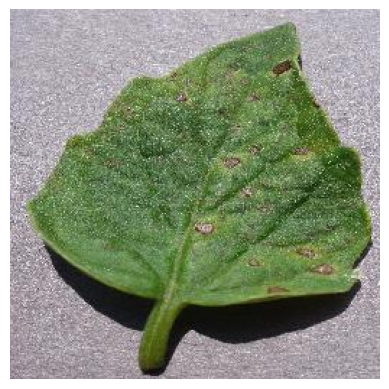

In [26]:
image_path=base_dir+'/Tomato___Septoria_leaf_spot/96090c07-dbf5-46e4-94bf-bf0d06cdf907___Matt.S_CG 7796.JPG'
img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
!pip install split-folders



In [35]:
import splitfolders

# Auto split: 70% train, 15% val, 15% test
splitfolders.ratio(
    base_dir, # source folder (all images)
    output="plantvillage_split",  # destination folder
    seed=42,
    ratio=(0.7, 0.15, 0.15)       # train, val, test ratio
)


Copying files: 54305 files [03:25, 264.56 files/s]


In [42]:
#Image parameter
img_size = 224
batch_size = 32

In [43]:
#image Data Generator with augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = data_gen.flow_from_directory(
    "plantvillage_split/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
)

# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


#validation generator
val_generator = data_gen.flow_from_directory(
    "plantvillage_split/val",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
)

test_gen = data_gen.flow_from_directory(
    "plantvillage_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("train image_shape:", train_generator.image_shape)

Found 37997 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.
Found 8179 images belonging to 38 classes.
train image_shape: (224, 224, 3)


In [44]:
num_classes = train_generator.num_classes
print(train_generator.num_classes)

38


In [45]:
#Tranfer Learning Model
#Load EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False


#Adding Custom Layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

#Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
]

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098,249 (15.63 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [47]:
#Train (Stage 1 – Only Dense Layer)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/2
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.0194 - loss: 3.6854 - val_accuracy: 0.0219 - val_loss: 3.6279 - learning_rate: 3.0000e-04
Epoch 2/2
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.0176 - loss: 3.7058 - val_accuracy: 0.0284 - val_loss: 3.6191 - learning_rate: 3.0000e-04


In [50]:
import tensorflow as tf

#Fine Tuning (Unfreeze EfficientNet)
base_model.trainable = True  # Unfreeze full model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:

#Train Again (Stage 2 – Fine-Tuning)
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    callbacks=callbacks
)

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 155s 131ms/step - accuracy: 0.9844 - loss: 0.0584 - val_accuracy: 0.9892 - val_loss: 0.0363 - learning_rate: 3.0000e-06


In [55]:
#Evaluate Model on Validation Set
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Loss: {val_loss:.4f}")


Evaluating model...
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9891 - loss: 0.0365
Validation Accuracy: 98.92%
Loss: 0.0363


In [56]:
#Evaluate model on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9900 - loss: 0.0321
Test Accuracy: 98.89%
Test Loss: 0.0358


In [60]:
#Combine Accuracy from Both Phases (history + history_fine)
full_train_acc = history.history['accuracy'] + history_fine.history['accuracy']
full_val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']


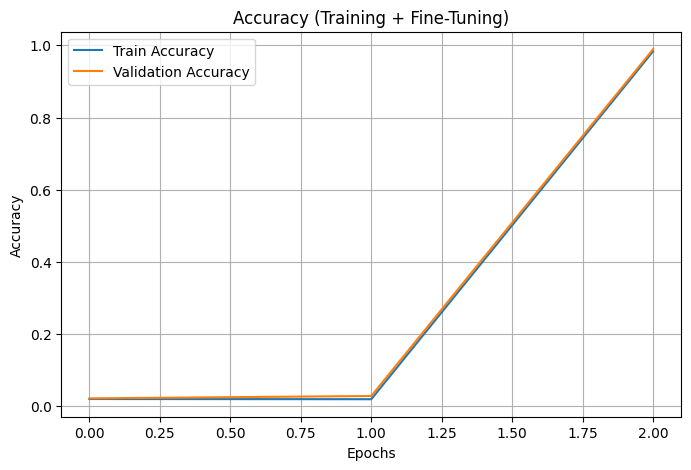

In [61]:
#Plot Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(full_train_acc, label='Train Accuracy')
plt.plot(full_val_acc, label='Validation Accuracy')
plt.title('Accuracy (Training + Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
#Combine Loss from Both Phases
full_train_loss = history.history['loss'] + history_fine.history['loss']
full_val_loss = history.history['val_loss'] + history_fine.history['val_loss']


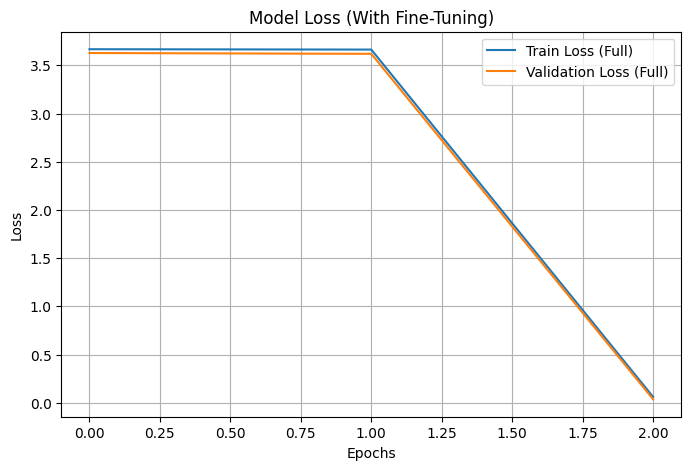

In [66]:

#Plot Loss Graph
plt.figure(figsize=(8, 5))
plt.plot(full_train_loss, label='Train Loss (Full)')
plt.plot(full_val_loss, label='Validation Loss (Full)')
plt.title('Model Loss (With Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Step 1: Get Predictions
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)  # convert probabilities to class index

#Step 2: Get True Labels
y_true = test_gen.classes

#Step 3: Class Names (to display readable output)
class_names = list(test_gen.class_indices.keys())

#Step 4: Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step
Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.96      0.98        95
                                 Apple___Black_rot       0.99      1.00      0.99        94
                          Apple___Cedar_apple_rust       0.98      1.00      0.99        42
                                   Apple___healthy       0.99      1.00      0.99       248
                               Blueberry___healthy       1.00      1.00      1.00       226
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       159
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       129
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.90      0.90        78
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       180
            

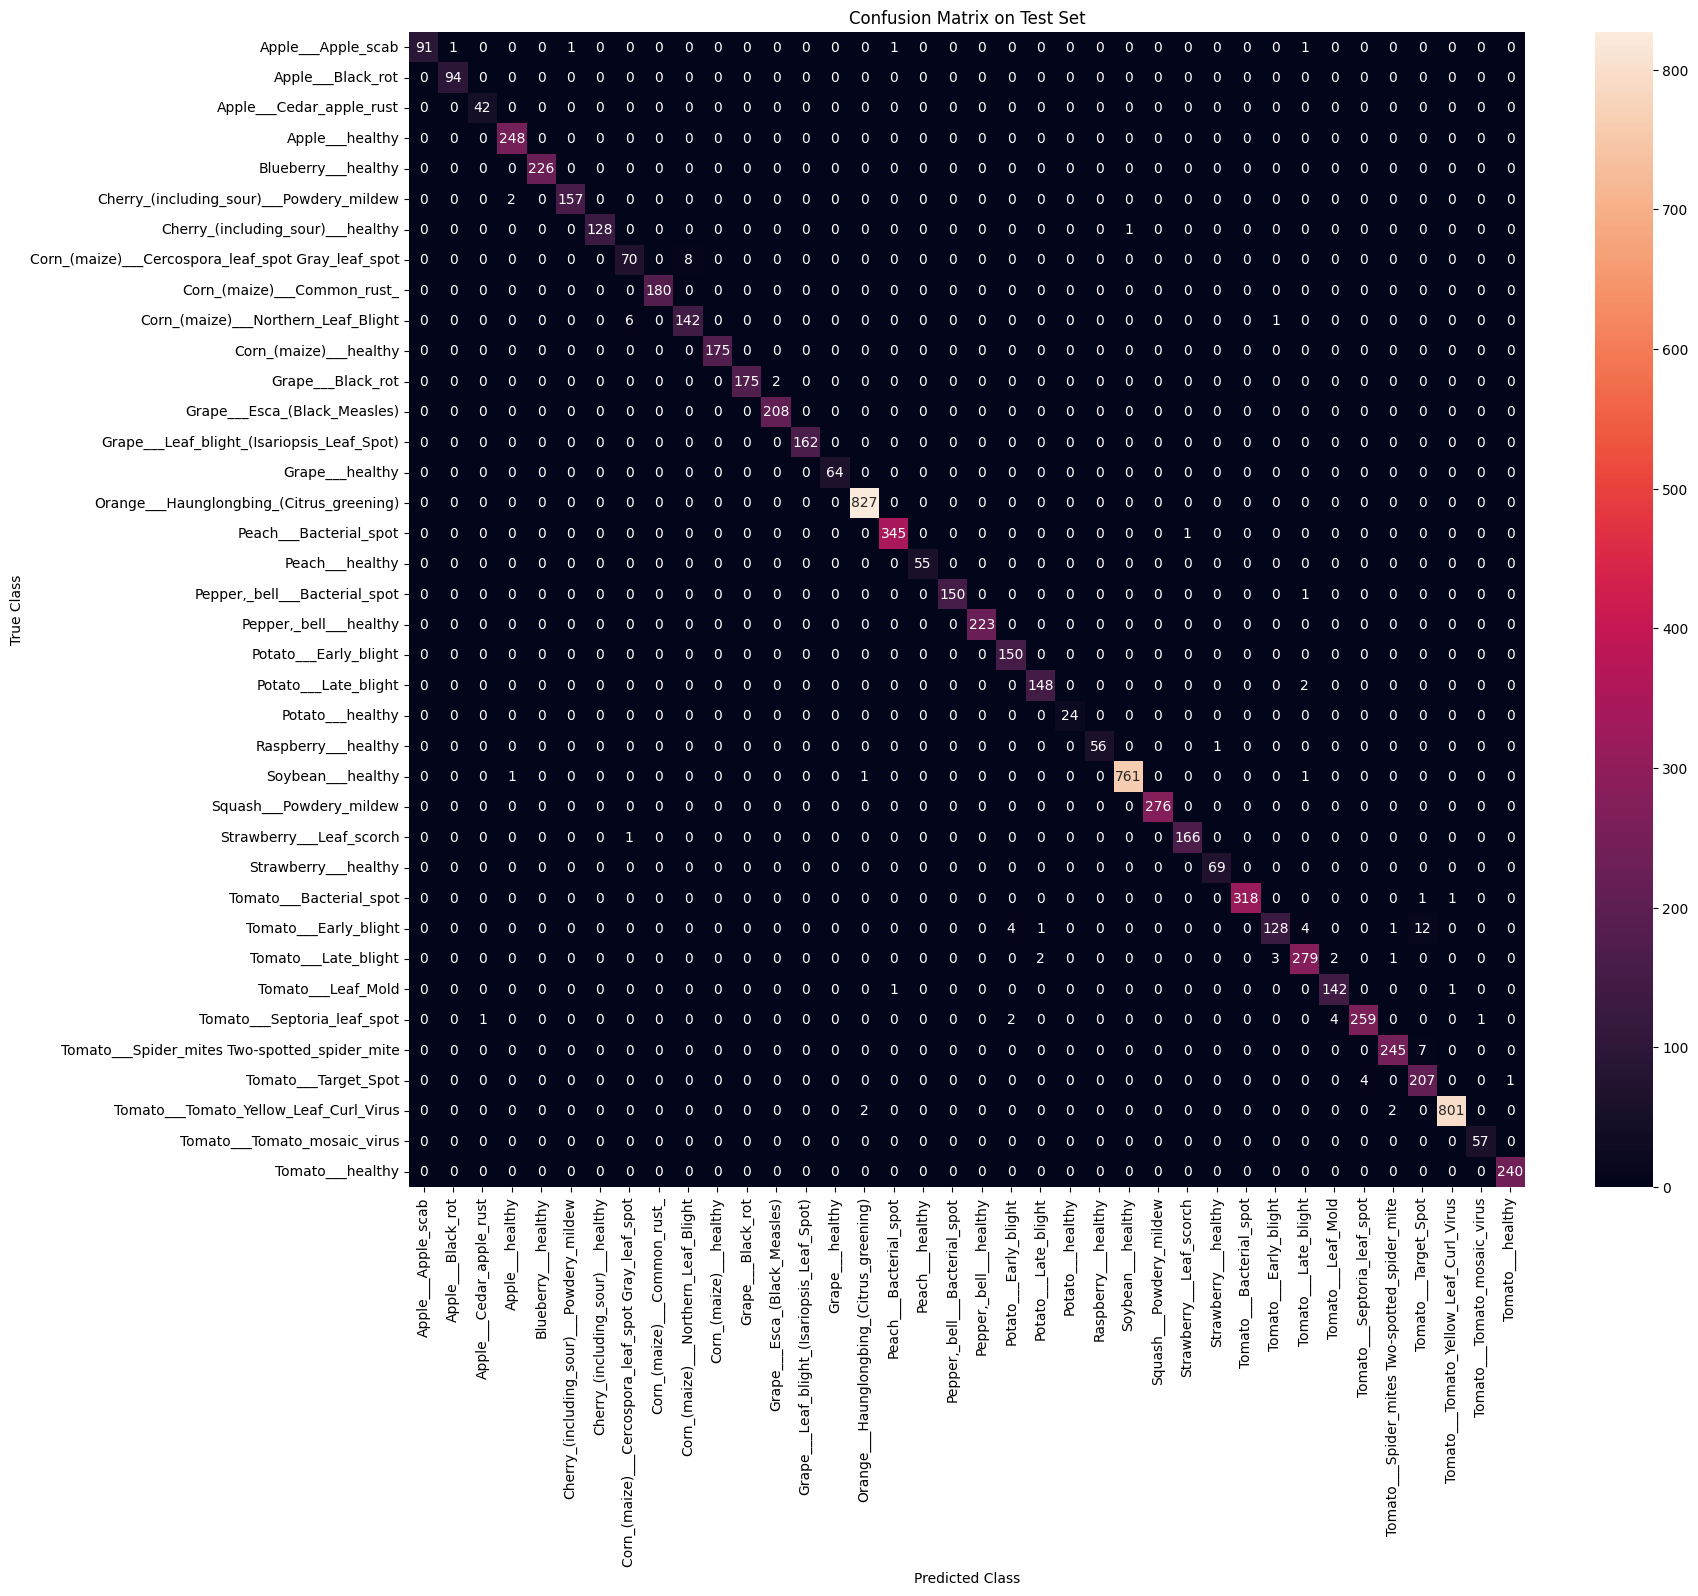

In [80]:
# Create Confusion Matrix for test set
cm = confusion_matrix(y_true, y_pred)

#Show Confusion Matrix as heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(cm, 
            annot=True,       # Change to True if you want numbers inside boxes
            fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [75]:
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "plantvillage_split/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False      #Must be False for correct label mapping
)


# Predictions on validation data
val_pred = model.predict(val_gen)
val_pred_classes = np.argmax(val_pred, axis=1)

# True labels from validation generator
val_true = val_gen.classes

# Class Labels
val_class_names = list(val_gen.class_indices.keys())

print("Validation Classification Report:\n")
print(classification_report(val_true, val_pred_classes, target_names=val_class_names))


Found 8129 images belonging to 38 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step
Validation Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.96      0.98        94
                                 Apple___Black_rot       0.98      0.99      0.98        93
                          Apple___Cedar_apple_rust       0.91      1.00      0.95        41
                                   Apple___healthy       0.99      1.00      0.99       246
                               Blueberry___healthy       0.99      1.00      1.00       225
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       157
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.92      0.91        76
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       178
 

In [83]:
import numpy as np
from PIL import Image

#Function to Load & Preprocess Image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')  # Ensure 3 channels
    img = img.resize(target_size)               # Resize to 224x224
    img_array = np.array(img) / 255.0           # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension: (1, 224, 224, 3)
    return img_array

#Function to Predict Image Class
def predict_image_class(model, image_path, class_indices):
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]

    # Class name from index
    predicted_class_name = class_indices[predicted_index]

    # Confidence score
    confidence = np.max(predictions) * 100

    return predicted_class_name, confidence

#Convert class_indices from {class_name: index} ➝ {index: class_name}
class_indices = {v: k for k, v in train_generator.class_indices.items()}

#Example to Test Prediction
image_path = "/kaggle/input/leaffff/test_leaf.jpg"  # ← Change with your own image path
predicted_class, confidence = predict_image_class(model, image_path, class_indices)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: Tomato___Early_blight
Confidence: 44.04%


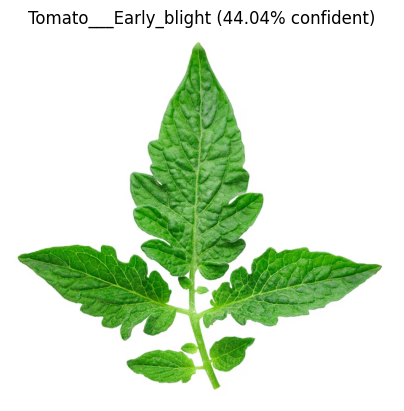

In [84]:
import matplotlib.pyplot as plt

def show_prediction(image_path, predicted_class, confidence):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence:.2f}% confident)")
    plt.show()

# To Display:
show_prediction(image_path, predicted_class, confidence)


In [85]:
# Save the trained model
model.save("plant_disease_model.h5")


In [86]:

with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

print("Class labels saved as class_indices.json")

Class labels saved as class_indices.json


In [87]:
!ls -lh


total 48M
-rw-r--r-- 1 root root 1.3K Nov  5 22:12 class_indices.json
-rw-r--r-- 1 root root  48M Nov  5 22:11 plant_disease_model.h5
drwxr-xr-x 5 root root 4.0K Nov  5 20:00 plantvillage_split
